In [1]:
from fit_completeness_to_catalog import *
import os
name = "sullivan"
cut_to_Ms = True
nwalkers = 24
ndim = 8
%load_ext autoreload
%autoreload 2

In [13]:
catalog, num_stars = get_catalog_and_numstars(name, cut_to_Ms)
num_stars = 200000
if os.path.isfile('synth{}.h5'.format(str(num_stars))):
    synth = pd.read_hdf('synth{}.h5'.format(str(num_stars)))
else:
    print("Making synth solar systems")
    synth = make_synth_solar_systems(num_stars=num_stars)
    synth.to_hdf('synth{}.h5'.format(str(num_stars)), key='synth')
synth = synth[synth.transit_bool]
hist_synth, hist_catalog = make_hists(synth, catalog, plot=False)
print("Injected {} transiting planets".format(int(np.sum(hist_synth))))

Selected 907 stars
Injected 12399 transiting planets


In [14]:
ll, p0 = make_mcmc_setup(hist_synth, hist_catalog, nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, ll)
_ = sampler.run_mcmc(p0, 10000, progress="notebook")
sampler.reset()
pos, _, _ = sampler.run_mcmc(p0, 50000, store=True, progress="notebook")

Found least-squares solution: [-1.66734715e-07  2.72052282e-01  6.84320374e-01  3.33668458e-02
  7.60038733e-02  3.92504557e-01  1.65524564e+00 -3.37767634e-01]
Set initial condition


In [5]:
i = 0
while True:
    try:
        print(sampler.get_autocorr_time())
        break
    except BaseException:
        newstart = np.median(sampler.chain[:,-1000:,:], axis=1)
        sampler.run_mcmc(newstart, 1000, store=True, progress='notebook')
        print(i)
        i += 1


0



1



2


emcee: Exception while calling your likelihood function:
  params: [-0.03513789 -0.01270102 -0.00487836  1.69465423  1.49310275 -0.1820664
  0.01281701 -0.85885338]
  args: []
  kwargs: {}
  exception:



Traceback (most recent call last):
  File "<ipython-input-5-c450bd58db5d>", line 4, in <module>
    print(sampler.get_autocorr_time())
  File "/Users/adityasengupta/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 526, in get_autocorr_time
    return self.backend.get_autocorr_time(**kwargs)
  File "/Users/adityasengupta/anaconda3/lib/python3.7/site-packages/emcee/backends/backend.py", line 150, in get_autocorr_time
    return thin * autocorr.integrated_time(x, **kwargs)
  File "/Users/adityasengupta/anaconda3/lib/python3.7/site-packages/emcee/autocorr.py", line 110, in integrated_time
    raise AutocorrError(tau_est, msg)
emcee.autocorr.AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1062;
tau: [4.76927375e+03 3.68620845e+03 3.02316949e+03 3.92857581e+03
 4.98069321e+03 4.67694742e+03 1.00000000e+00 4.62290356e+03]

During handling of the above exception

KeyboardInterrupt: 

In [ ]:
sampler.get_autocorr_time()

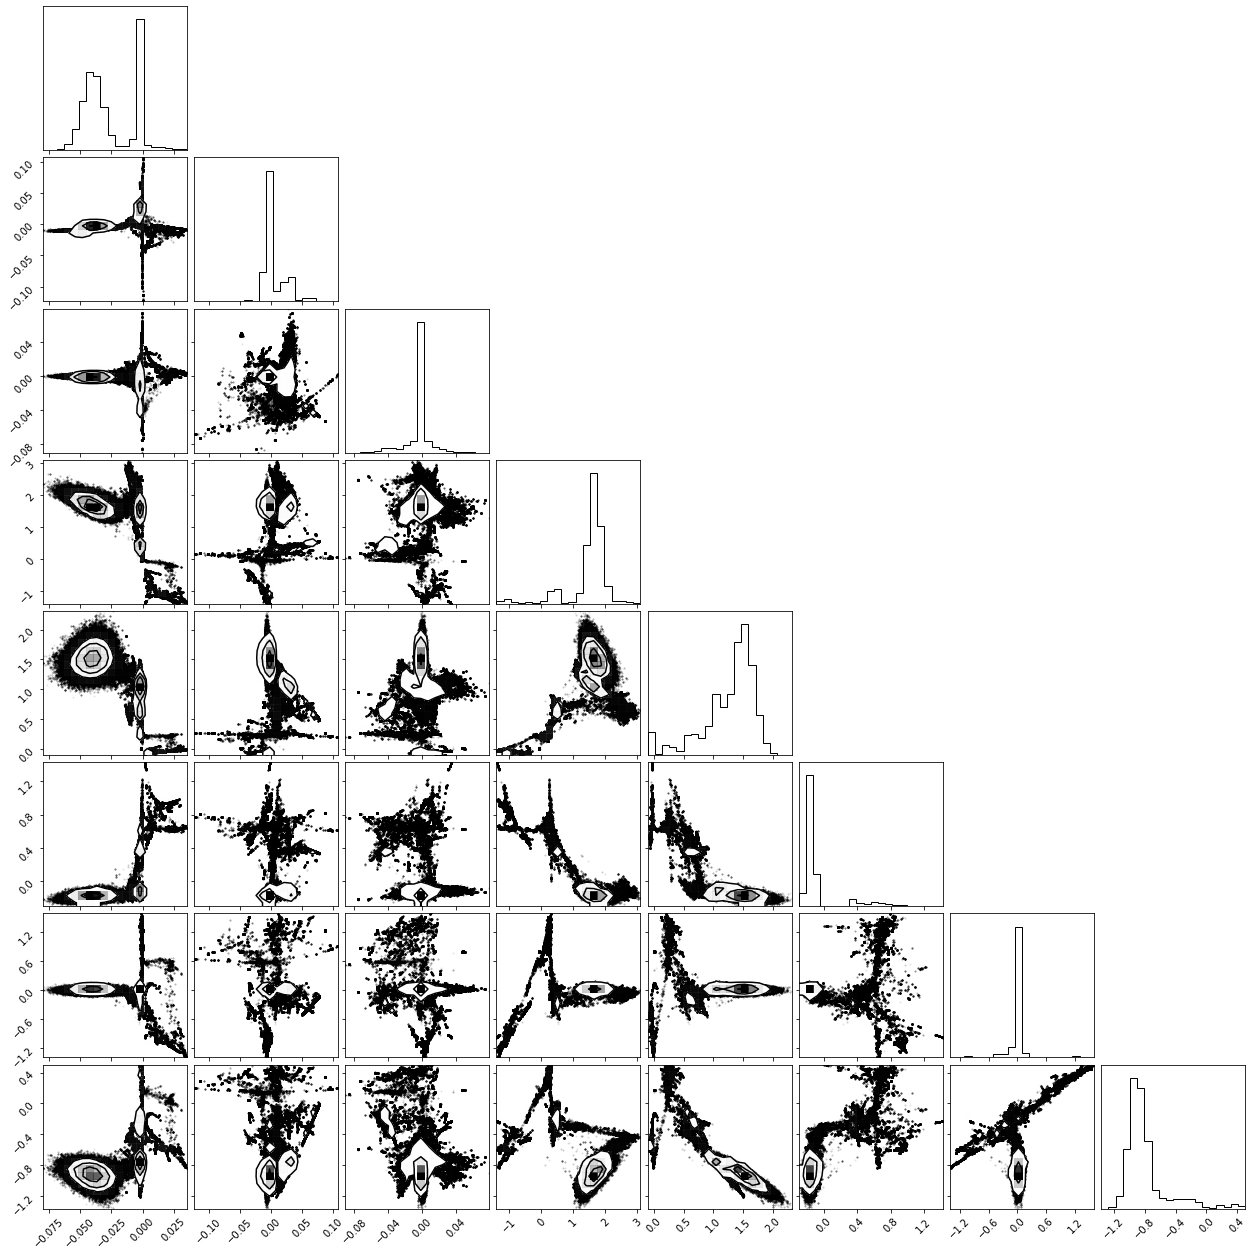

In [6]:
_ = corner.corner(sampler.flatchain) # check autocorrelation times

In [7]:
from IPython.display import display, Math
labels = ['p0', 'p1', 'p2', 'p3', 'r0', 'r1', 'r2', 'r3']

best_params = np.empty(ndim,)
for i in range(ndim):
    mcmc = np.percentile(sampler.get_chain(discard=100, thin=15, flat=True)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    best_params[i] = mcmc[1]
    display(Math(txt))
# cut off days at 27, or at 90th percentile for TOIs||

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [8]:
comp_p = comp_poly(bins_p, *best_params[:4])
comp_r = comp_poly(bins_r, *best_params[4:])
comp_p -= np.min(comp_p)
comp_p /= np.max(comp_p)
comp_r -= np.min(comp_r)
comp_r /= np.max(comp_r)

In [9]:
comp_p

array([1.        , 0.99393598, 0.9840001 , 0.96777867, 0.9414535 ,
       0.89915727, 0.83234269, 0.72983215, 0.58049567, 0.38309584,
       0.17004046, 0.0346958 , 0.        ])

In [10]:
comp_r

array([0.        , 0.03777423, 0.07969209, 0.12602225, 0.17698919,
       0.23274729, 0.29334783, 0.35869742, 0.42850746, 0.50223432,
       0.57901183, 0.65757985, 0.7362174 , 0.8126957 , 0.88427845,
       0.94781483, 1.        ])

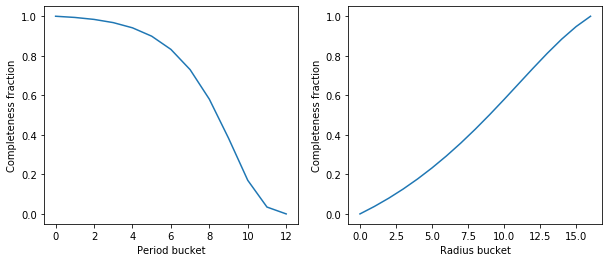

In [11]:
plot_marginalized_comps(comp_p, comp_r)

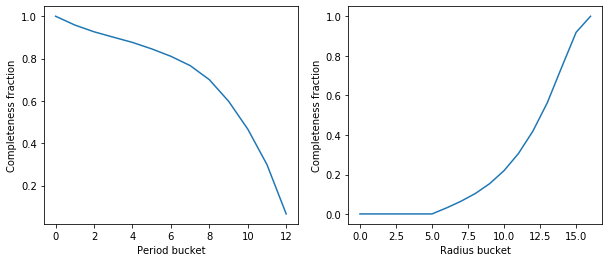

In [12]:
comp04m = np.load('ballard_data/Completeness_0.4Msun.npy')
num_iters = 100
rcomp_marginalized = np.mean(comp04m[-1].dot(np.random.uniform(size=(13,num_iters))), axis=1)
rcomp_marginalized /= rcomp_marginalized[-1]
pcomp_marginalized = np.mean(comp04m[-1].T.dot(np.random.uniform(size=(17,num_iters))), axis=1)
pcomp_marginalized /= pcomp_marginalized[0]
plot_marginalized_comps(pcomp_marginalized, rcomp_marginalized)

In [ ]:
repcomp = np.outer(comp_p, comp_r).T
plot_overall_comps(repcomp, name)